# Lab: Working with multiple models

In this notebook, we will look at the London Borough data that we already encountered when we worked with the London Borough profiles and the Borough Cards that we utilised in the session.

You can have a look at the data through this online tool provided by GLA: <https://data.london.gov.uk/london-area-profiles/>

However, unlike the data that we explored during the session, this data set has several features (i.e., columns or variables), 76 of them to be precise.

What we would like to do in this notebook is to make use of a dimension reduction algorithm -- Multidimensional Scaling -- to help us create various different "spaces". Each of these space will be a different way of "seeing this data" and if we adopt the language from Scott Page [-@pageWhyManyModelThinkers2018], they will have different "attentions". 

What the following exercise will do is to walk you through the variables of this data set through a few visualisations. It will then create a few different projections and will give them some names. What we expect you to do is to create your own projections and try to interpret them. 

If you want to be reminded of what MDS is, you can have a look at the slides from last week. In a super tiny nutshell, MDS tries to create a space where "real" distances in the data are preserved as much as possible while "projecting" the data elements on a lower dimensional space. For instance, the following is from the slide deck:

![An MDS plot of cities.](figs/mds.png){width=800}

What we see here are a few cities that would normally "exist" in our 3-dimensional world and the distances between them would normally be on this spherical coordinate system. But we create here is a 2D map and the distances between cities are preserved as much as possible. Near cities in the world are closer, and the further ones are further but not as accurate as it is in the world. The dimensions here carry no real meaning it is the distances that will "tell a story" (if there is one).

OK, let's get on with the data now.

## Data exploration and wrangling

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd

df = pd.read_excel('data/london-borough-profilesV3.xlsx', engine = 'openpyxl')
df.columns

Index(['Code', 'Area/INDICATOR', 'Inner/ Outer London',
       'GLA Population Estimate 2013', 'GLA Household Estimate 2013',
       'Inland Area (Hectares)', 'Population density (per hectare) 2013',
       'Average Age, 2013', 'Proportion of population aged 0-15, 2013',
       'Proportion of population of working-age, 2013',
       'Proportion of population aged 65 and over, 2013',
       '% of resident population born abroad (2013)',
       'Largest migrant population by country of birth (2013)',
       '% of largest migrant population (2013)',
       'Second largest migrant population by country of birth (2013)',
       '% of second largest migrant population (2013)',
       'Third largest migrant population by country of birth (2013)',
       '% of third largest migrant population (2013)',
       '% of population from BAME groups (2013)',
       '% people aged 3+ whose main language is not English (2011 census)',
       'Overseas nationals entering the UK (NINo), (2013/14)',
      

In [2]:
df.head()

,Code,Area/INDICATOR,Inner/ Outer London,GLA Population Estimate 2013,GLA Household Estimate 2013,Inland Area (Hectares),Population density (per hectare) 2013,"Average Age, 2013","Proportion of population aged 0-15, 2013","Proportion of population of working-age, 2013",...,Teenage conception rate (2012),Life satisfaction score 2012-13 (out of 10),Worthwhileness score 2012-13 (out of 10),Happiness score 2012-13 (out of 10),Anxiety score 2012-13 (out of 10),Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
0,E09000001,City of London,Inner London,8000,4514.371383,290.4,27.525868,41.303887,7.948036,77.541617,...,.,8.10,8.23,7.44,x,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,Outer London,195600,73261.408580,3610.8,54.160527,33.228935,26.072939,63.835021,...,35.4,7.06,7.57,6.97,3.3,Lab,0.000000,100.000000,0.000000,38.16
2,E09000003,Barnet,Outer London,370000,141385.794900,8674.8,42.651374,36.896246,20.886408,65.505593,...,14.7,7.35,7.79,7.27,2.63,Cons,50.793651,42.857143,1.587302,41.1
3,E09000004,Bexley,Outer London,236500,94701.226400,6058.1,39.044243,38.883039,20.282830,63.146450,...,25.8,7.47,7.75,7.21,3.22,Cons,71.428571,23.809524,0.000000,not avail
4,E09000005,Brent,Outer London,320200,114318.553900,4323.3,74.063670,35.262694,20.462585,68.714872,...,19.6,7.23,7.32,7.09,3.33,Lab,9.523810,88.888889,1.587302,33


Lots of different features. We also have really odd `NaN` values such as `x` and `not available`. We can try and get rid of this.

In [3]:
def isnumber(x):
    try:
        float(x)
        return True
    except:
        if (len(x) > 1) & ("not avail" not in x):
            return True
        else:
            return False

# apply isnumber function to every element
df = df[df.applymap(isnumber)]
df.head()

,Code,Area/INDICATOR,Inner/ Outer London,GLA Population Estimate 2013,GLA Household Estimate 2013,Inland Area (Hectares),Population density (per hectare) 2013,"Average Age, 2013","Proportion of population aged 0-15, 2013","Proportion of population of working-age, 2013",...,Teenage conception rate (2012),Life satisfaction score 2012-13 (out of 10),Worthwhileness score 2012-13 (out of 10),Happiness score 2012-13 (out of 10),Anxiety score 2012-13 (out of 10),Political control in council,Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election,Turnout at 2014 local elections
0,E09000001,City of London,Inner London,8000,4514.371383,290.4,27.525868,41.303887,7.948036,77.541617,...,NaN,8.10,8.23,7.44,NaN,NaN,NaN,NaN,NaN,NaN
1,E09000002,Barking and Dagenham,Outer London,195600,73261.408580,3610.8,54.160527,33.228935,26.072939,63.835021,...,35.4,7.06,7.57,6.97,3.3,Lab,0.000000,100.000000,0.000000,38.16
2,E09000003,Barnet,Outer London,370000,141385.794900,8674.8,42.651374,36.896246,20.886408,65.505593,...,14.7,7.35,7.79,7.27,2.63,Cons,50.793651,42.857143,1.587302,41.1
3,E09000004,Bexley,Outer London,236500,94701.226400,6058.1,39.044243,38.883039,20.282830,63.146450,...,25.8,7.47,7.75,7.21,3.22,Cons,71.428571,23.809524,0.000000,NaN
4,E09000005,Brent,Outer London,320200,114318.553900,4323.3,74.063670,35.262694,20.462585,68.714872,...,19.6,7.23,7.32,7.09,3.33,Lab,9.523810,88.888889,1.587302,33


That looks much cleaner.

Replace the `NaN` values in numeric columns with the mean.

In [4]:
# get only numeric columns
numericColumns = df._get_numeric_data()

In [5]:
from sklearn.metrics import euclidean_distances

# keep place names and store them in a variable
placeNames = df["Area/INDICATOR"]

# let's fill the missing values with mean()
numericColumns = numericColumns.fillna(numericColumns.mean())

# let's centralize the data
numericColumns -= numericColumns.mean()

# now we compute the euclidean distances between the columns by passing the same data twice
# the resulting data matrix now has the pairwise distances between the boroughs.
# CAUTION: note that we are now building a distance matrix in a high-dimensional data space
# remember the Curse of Dimensionality -- we need to be cautious with the distance values
distMatrix = euclidean_distances(numericColumns, numericColumns)

Check to make sure everything looks ok.

In [6]:
numericColumns.head()

,GLA Population Estimate 2013,GLA Household Estimate 2013,Inland Area (Hectares),Population density (per hectare) 2013,"Average Age, 2013","Proportion of population aged 0-15, 2013","Proportion of population of working-age, 2013","Proportion of population aged 65 and over, 2013",% of population from BAME groups (2013),% people aged 3+ whose main language is not English (2011 census),...,"Average Public Transport Accessibility score, 2012",Indices of Multiple Deprivation 2010 Rank of Average Score,Income Support claimant rate (Feb-14),Rates of Children Looked After (2013),Life satisfaction score 2012-13 (out of 10),Worthwhileness score 2012-13 (out of 10),Happiness score 2012-13 (out of 10),Proportion of seats won by Conservatives in 2014 election,Proportion of seats won by Labour in 2014 election,Proportion of seats won by Lib Dems in 2014 election
0,-247760.606061,-97761.616805,-4473.681818,-43.279630,5.426932,-11.500067,8.480871,3.019196,-17.390874,-4.491385,...,3.753658,157.424242,-1.726749,42.212121,0.816364,0.651212,0.23303,0.000000,0.000000,-8.881784e-16
1,-60160.606061,-29014.579608,-1153.281818,-16.644971,-2.648021,6.624837,-5.225725,-1.399112,5.764246,-2.905288,...,-0.882730,-82.575758,1.787041,20.212121,-0.223636,-0.008788,-0.23697,-32.854444,43.384181,-6.598065e+00
2,114239.393939,39109.806712,3910.718182,-28.154125,1.019290,1.438305,-3.555153,2.116847,-2.799300,1.775548,...,-0.883020,71.424242,-0.517827,-18.787879,0.066364,0.211212,0.06303,17.939207,-13.758676,-5.010764e+00
3,-19260.606061,-7574.761788,1294.018182,-31.761255,3.006083,0.834727,-5.914296,5.079569,-20.328016,-15.598200,...,-1.364540,69.424242,-0.018377,-8.787879,0.186364,0.171212,0.00303,38.574127,-32.806295,-6.598065e+00
4,64439.393939,12042.565712,-440.781818,3.258171,-0.614262,1.014482,-0.345874,-0.668608,25.000030,15.521631,...,-0.174795,-69.575758,0.001370,-6.787879,-0.053636,-0.258788,-0.11697,-23.330634,32.273070,-5.010764e+00


We can plot out our many dimension space by uncommenting the code below (also note down how long does this take).

In [7]:
#import seaborn as sns
#sns_plot = sns.pairplot(numericColumns)
#sns_plot.savefig("figs/output.png")

Given that this takes quite a while (around 10 minutes), this is the image that would result from uncommenting and running the code above.

:::{.column-page}
![](figs/output.png)
:::

## Dimension reduction

Dimension reduction will help us here!

We could apply various different types of dimension reduction here. We are specifically going to capture the dissimilarity in the data using [multidimensional scaling](https://scikit-learn.org/stable/modules/manifold.html#multidimensional-scaling). Our distance matrix will come in useful here.

In [8]:
from sklearn import manifold
# for instance, typing distMatrix.shape on the console gives:
# Out[115]: (38, 38) # i.e., the number of rows

# first we generate an MDS object and extract the projections
mds = manifold.MDS(n_components = 2, max_iter=3000, n_init=1, dissimilarity="precomputed", normalized_stress=False)
Y = mds.fit_transform(distMatrix)

To interpret what is happening, let us plot the boroughs on the projected two dimensional space.

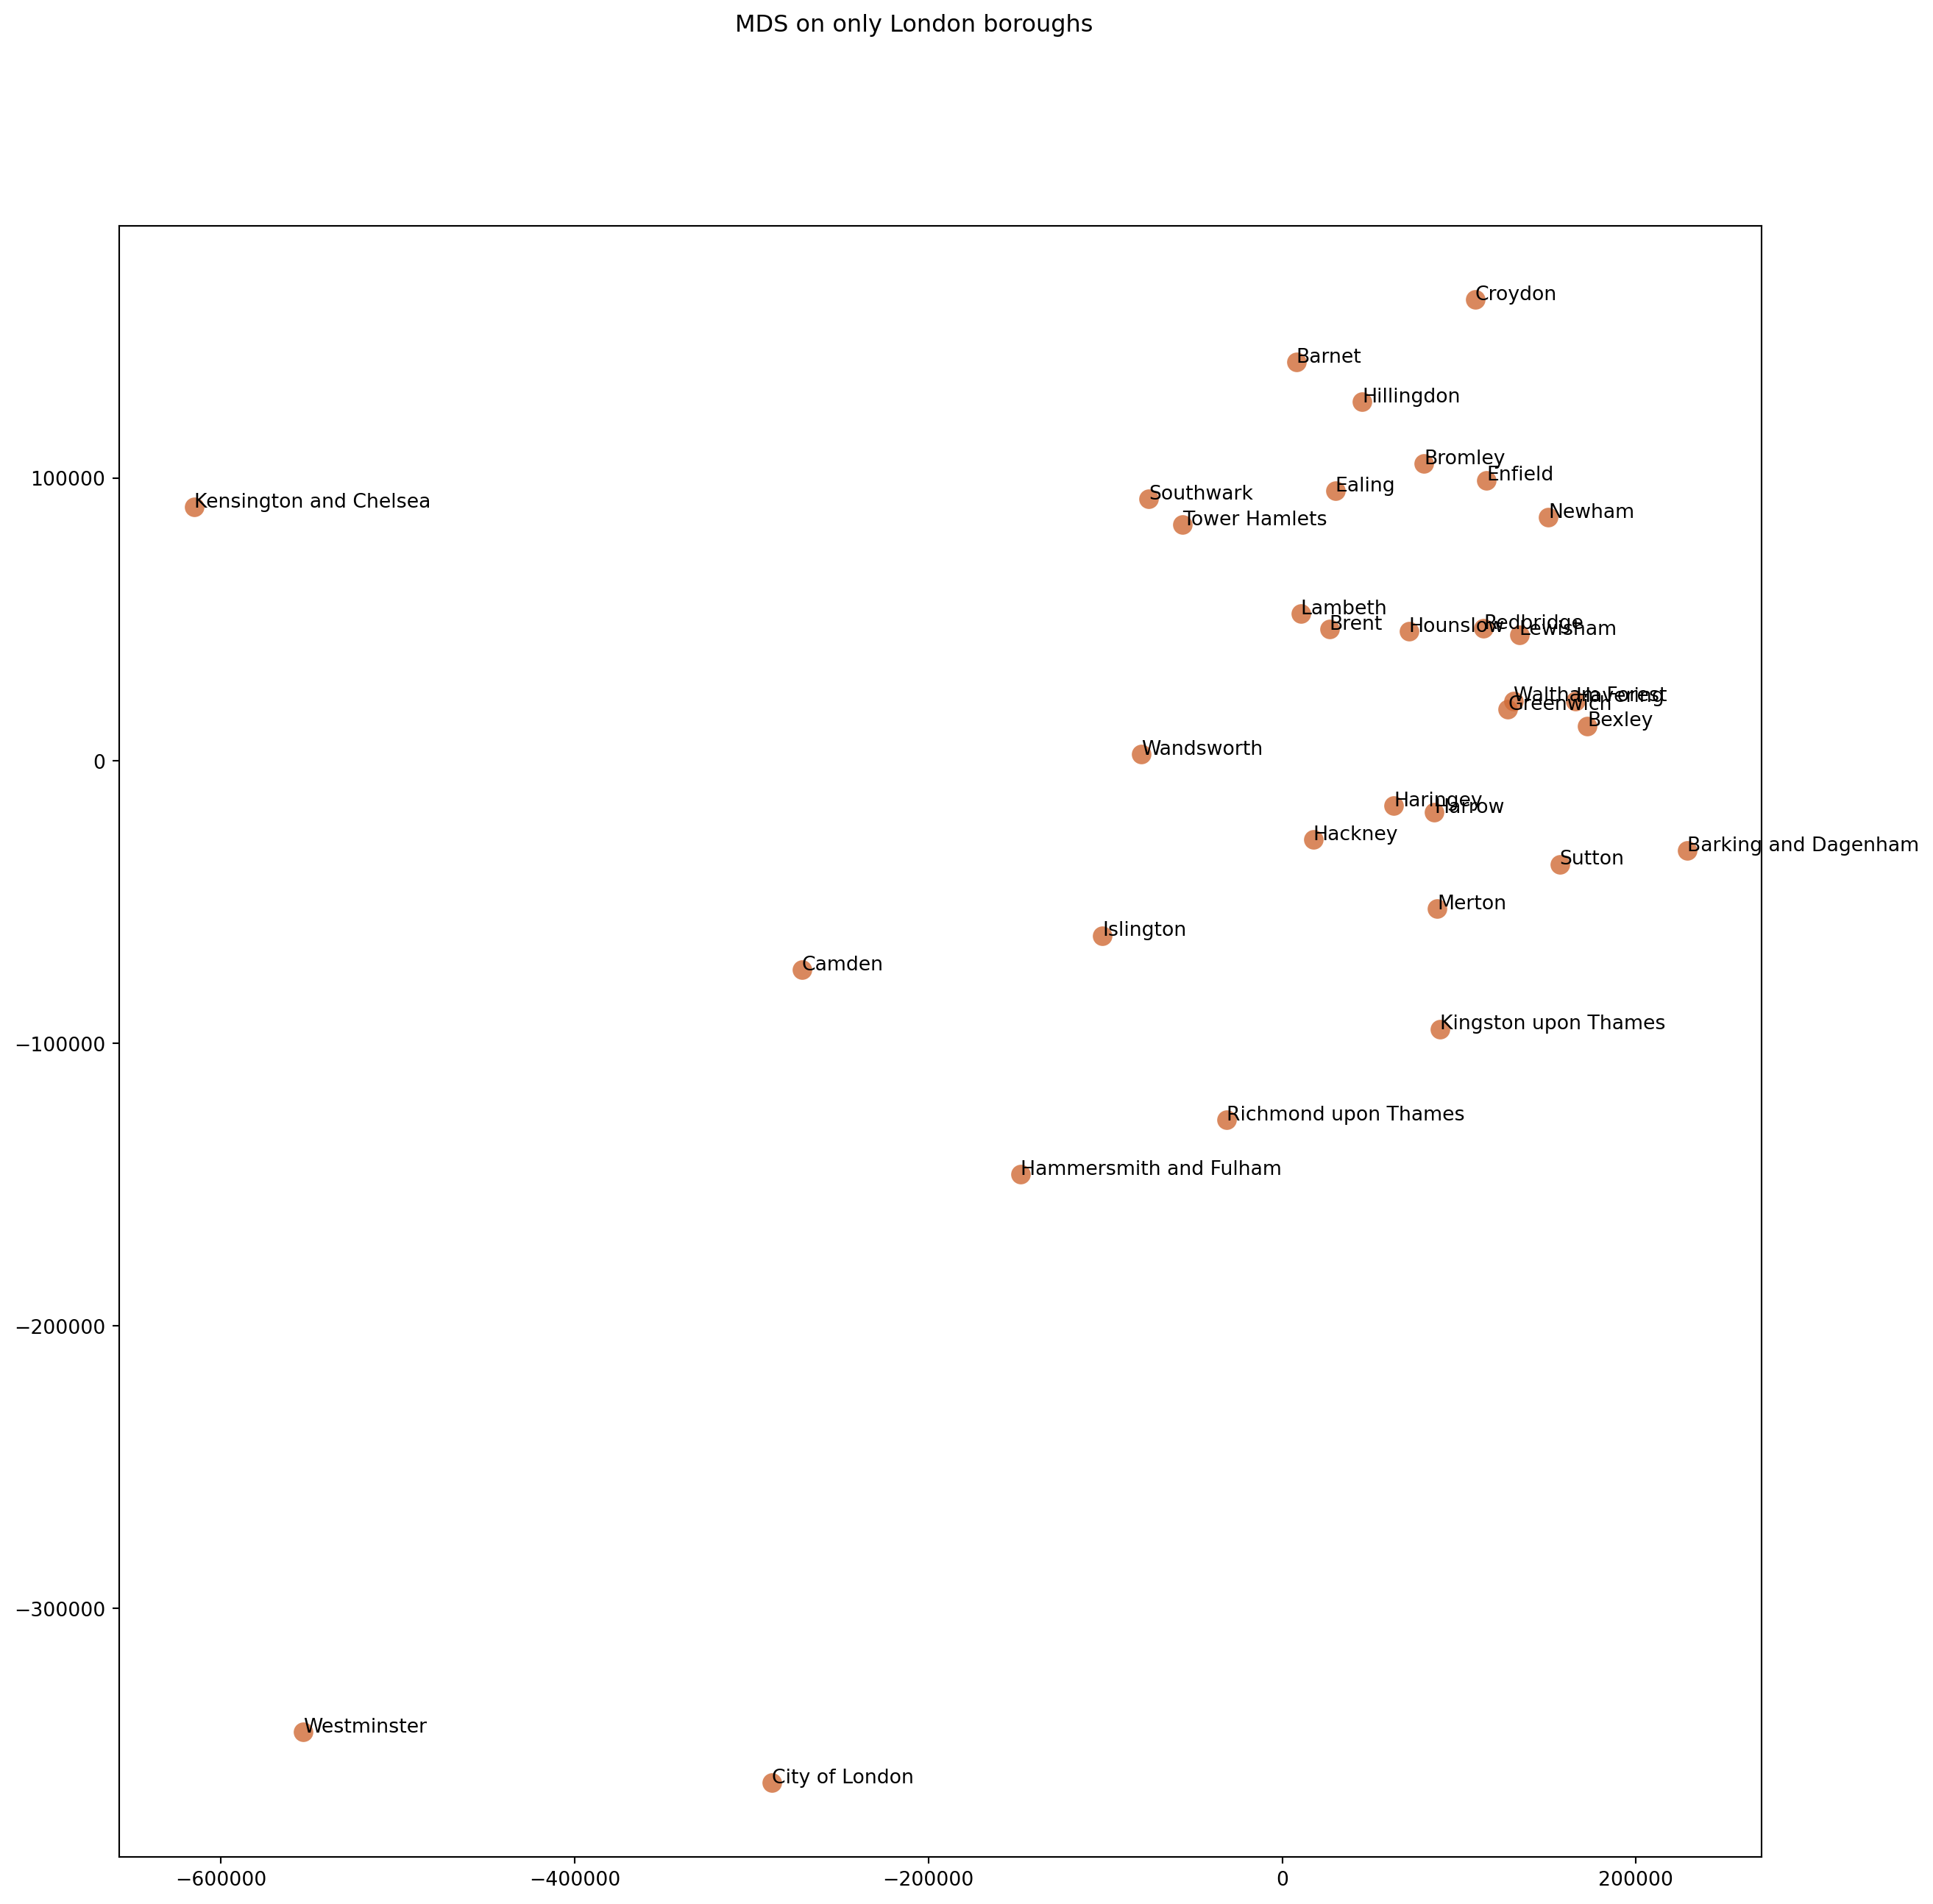

In [9]:
#| column: page

from matplotlib import pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.suptitle('MDS on only London boroughs')
ax.scatter(Y[:, 0], Y[:, 1], c="#D06B36", s = 100, alpha = 0.8, linewidth=0)

for i, txt in enumerate(placeNames):
    ax.annotate(txt, (Y[:, 0][i],Y[:, 1][i]))

Our data also include happiness metrics. Pulling these out of our data and carrying out more multidimensional scaling can help us see how the boroughs differ in happiness.

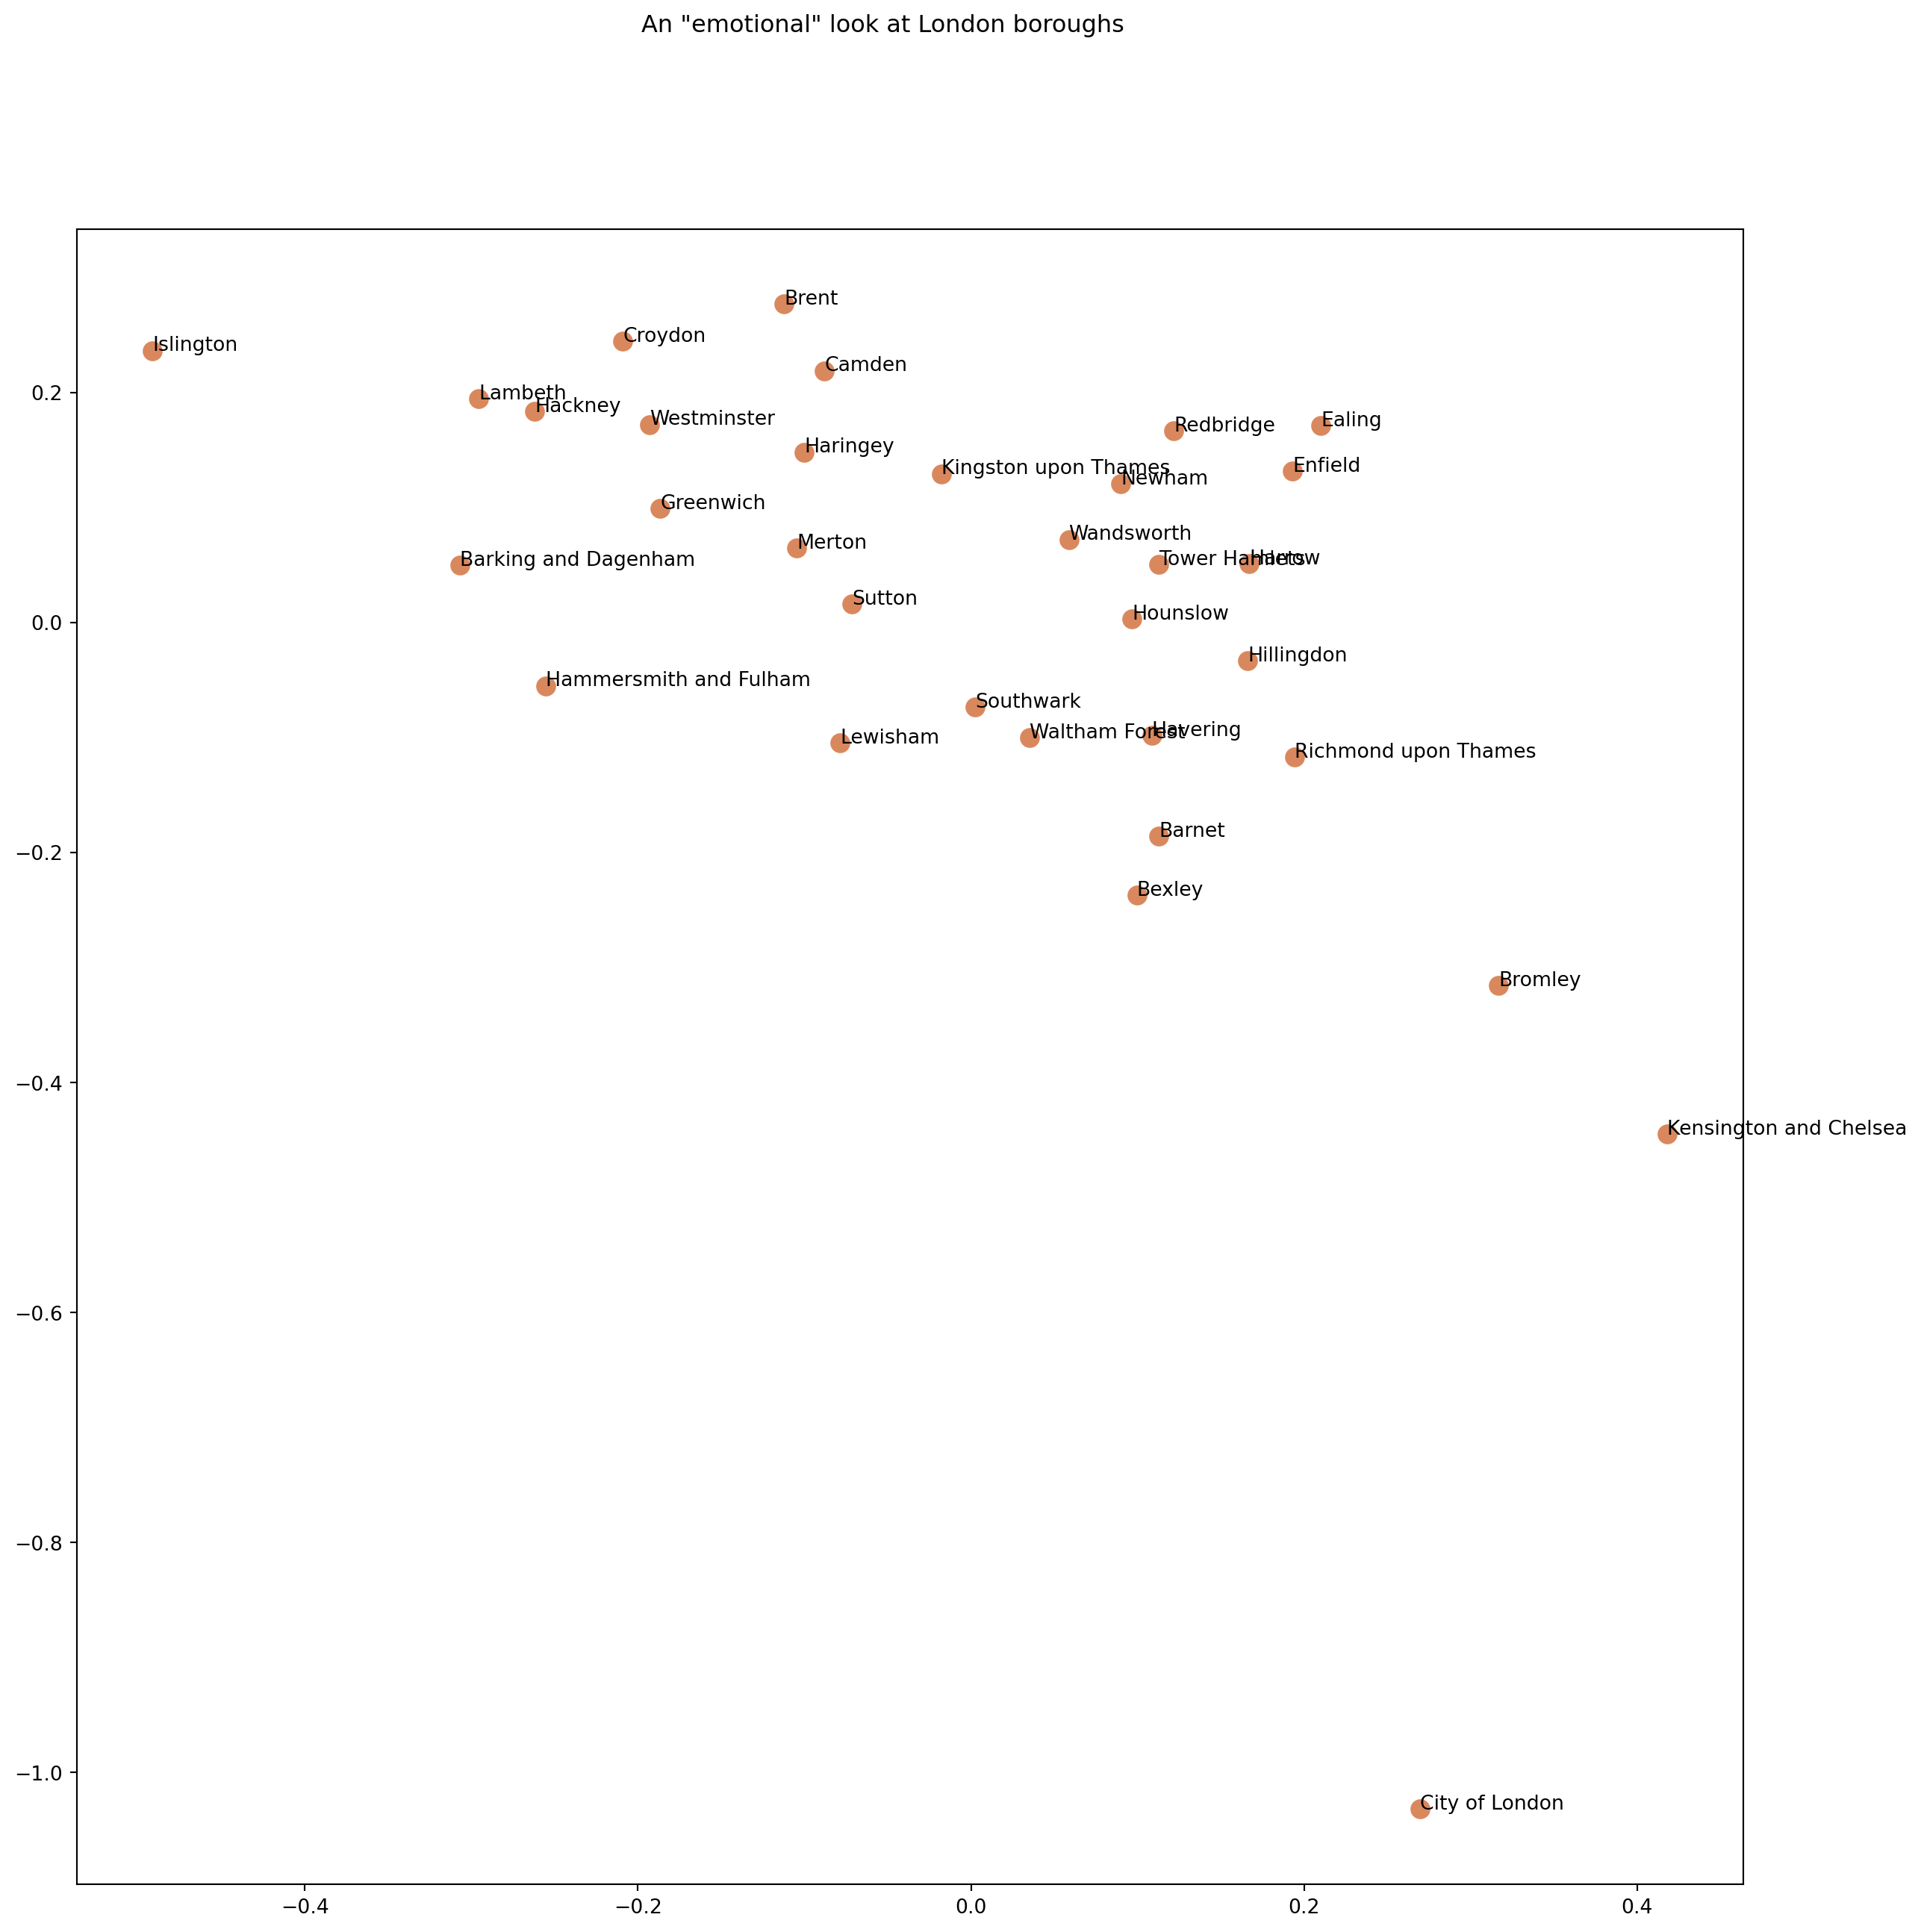

In [10]:
#| column: page

# get the data columns relating to emotions and feelings
dataOnEmotions = numericColumns[["Life satisfaction score 2012-13 (out of 10)", "Worthwhileness score 2012-13 (out of 10)","Happiness score 2012-13 (out of 10)"]]

# a new distance matrix to represent "emotional distance"s
distMatrix2 = euclidean_distances(dataOnEmotions, dataOnEmotions)

# compute a new "embedding" (machine learners' word for projection)
Y2 = mds.fit_transform(distMatrix2)

# let's look at the results
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.suptitle('An \"emotional\" look at London boroughs')
ax.scatter(Y2[:, 0], Y2[:, 1], c="#D06B36", s = 100, alpha = 0.8, linewidth=0)

for i, txt in enumerate(placeNames):
    ax.annotate(txt, (Y2[:, 0][i],Y2[:, 1][i]))

The location of the different boroughs on the 2 dimensional multidimensional scaling space from the happiness metrics is

In [11]:
results_fixed = Y2.copy()
print(results_fixed)

[[ 0.26955023 -1.03193546]
 [-0.30697124  0.04988649]
 [ 0.11267823 -0.18603719]
 [ 0.09951239 -0.23709264]
 [-0.11233607  0.27677033]
 [ 0.31687906 -0.31587447]
 [-0.08799261  0.21880538]
 [-0.20905701  0.24461554]
 [ 0.21012164  0.17125381]
 [ 0.19306487  0.13163987]
 [-0.18659     0.0989468 ]
 [-0.2618981   0.18342251]
 [-0.2551384  -0.05507685]
 [-0.10018359  0.14805073]
 [ 0.16711463  0.05098098]
 [ 0.10854867 -0.09812561]
 [ 0.16605853 -0.03341054]
 [ 0.09654886  0.00279667]
 [-0.49153577  0.23630239]
 [ 0.4181435  -0.44518512]
 [-0.01774271  0.12920108]
 [-0.29575096  0.19446001]
 [-0.07852039 -0.10487395]
 [-0.10459205  0.06451135]
 [ 0.09001571  0.12021746]
 [ 0.12164733  0.16641986]
 [ 0.19424041 -0.11717992]
 [ 0.00238345 -0.07364946]
 [-0.07160448  0.01590297]
 [ 0.11278589  0.05034198]
 [ 0.03510502 -0.10010882]
 [ 0.05868884  0.07204286]
 [-0.19317386  0.17198096]]


We may want to look at if the general happiness rating captures the position of the boroughs. To do this we need to assign colours based on the binned happiness score.

In [12]:
import numpy as np

colorMappingValuesHappiness = np.asarray(dataOnEmotions[["Life satisfaction score 2012-13 (out of 10)"]]).flatten()
print(results_fixed.shape)
colorMappingValuesHappiness.shape

colorMappingValuesHappiness
#c = colorMappingValuesCrime, cmap = plt.cm.Greens

(33, 2)


array([ 0.81636364, -0.22363636,  0.06636364,  0.18636364, -0.05363636,
        0.34636364, -0.06363636, -0.28363636, -0.04363636, -0.10363636,
       -0.12363636, -0.21363636, -0.05363636, -0.08363636,  0.05636364,
        0.11636364,  0.06636364,  0.01636364, -0.20363636,  0.39636364,
        0.00636364, -0.19363636, -0.05363636, -0.10363636, -0.06363636,
       -0.00363636,  0.13636364, -0.01363636, -0.03363636, -0.00363636,
       -0.04363636, -0.05363636, -0.19363636])

Finally, we can plot this. What can you see?

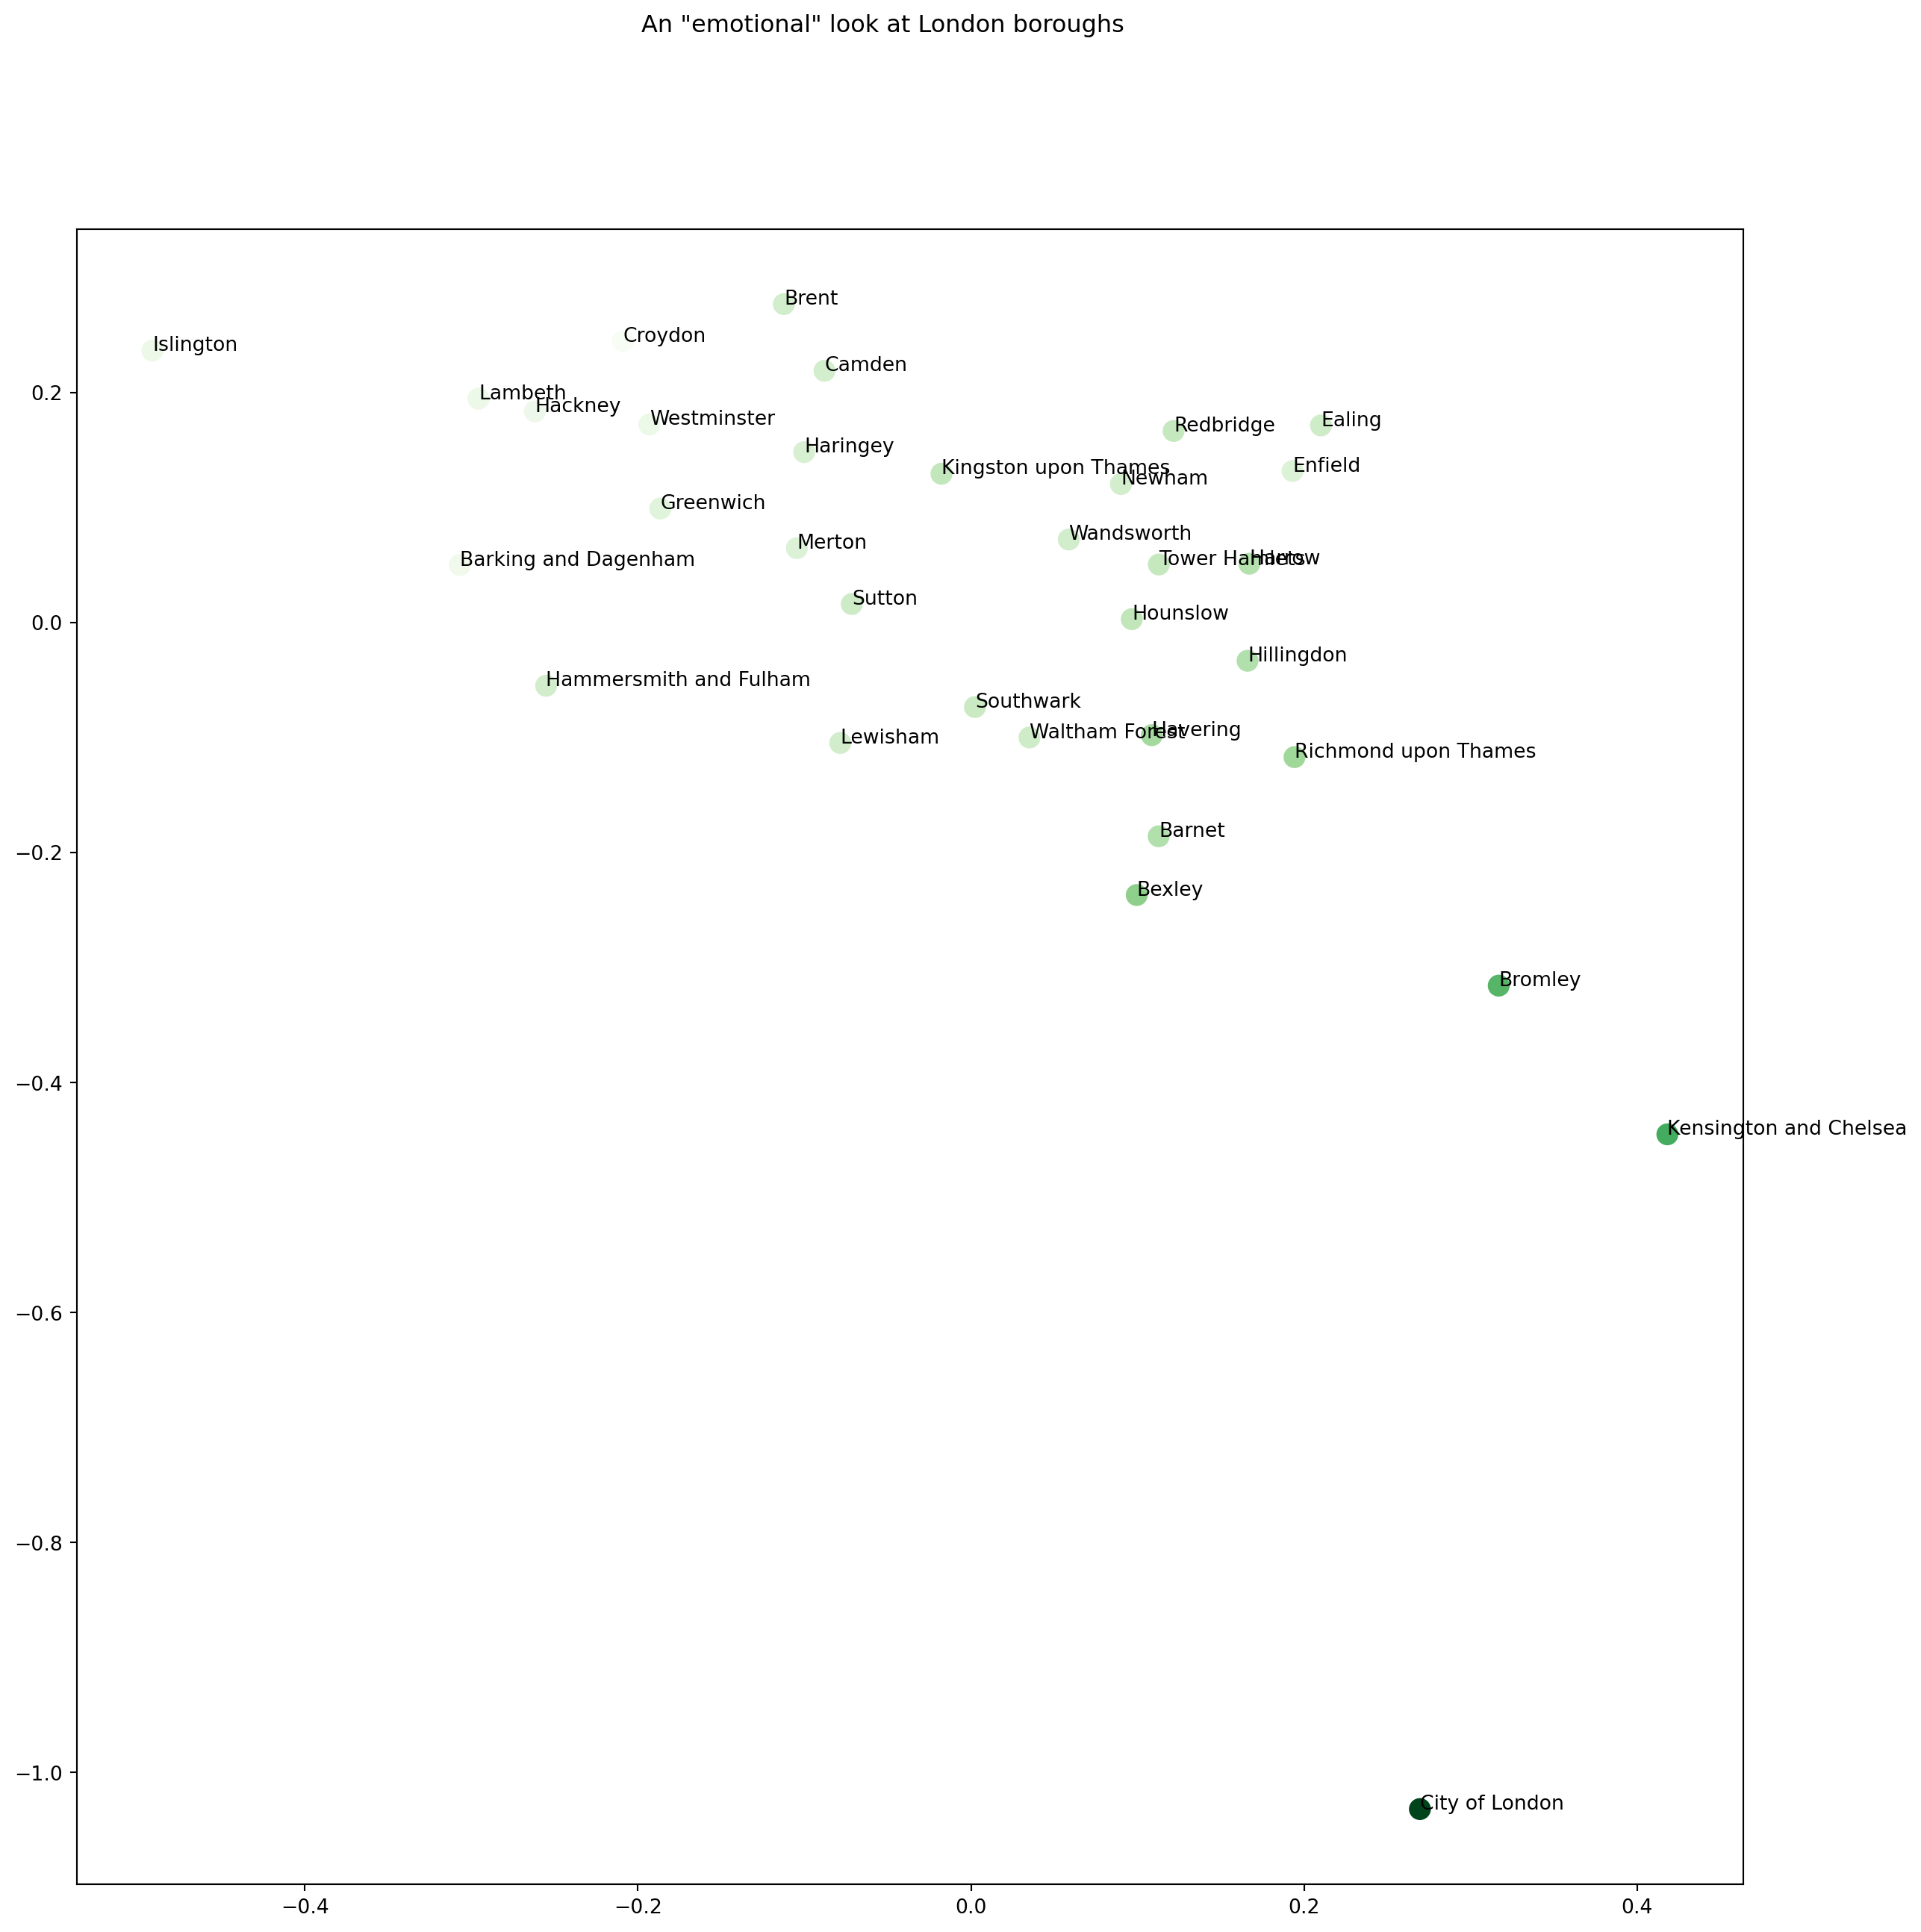

In [13]:
#| column: page

# let's look at the results
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.suptitle('An \"emotional\" look at London boroughs')
#ax.scatter(results_fixed[:, 0], results_fixed[:, 1], c = colorMappingValuesHappiness, cmap='viridis')
plt.scatter(results_fixed[:, 0], results_fixed[:, 1], c = colorMappingValuesHappiness, s = 100, cmap=plt.cm.Greens)

for i, txt in enumerate(placeNames):
    ax.annotate(txt, (results_fixed[:, 0][i],results_fixed[:, 1][i]))

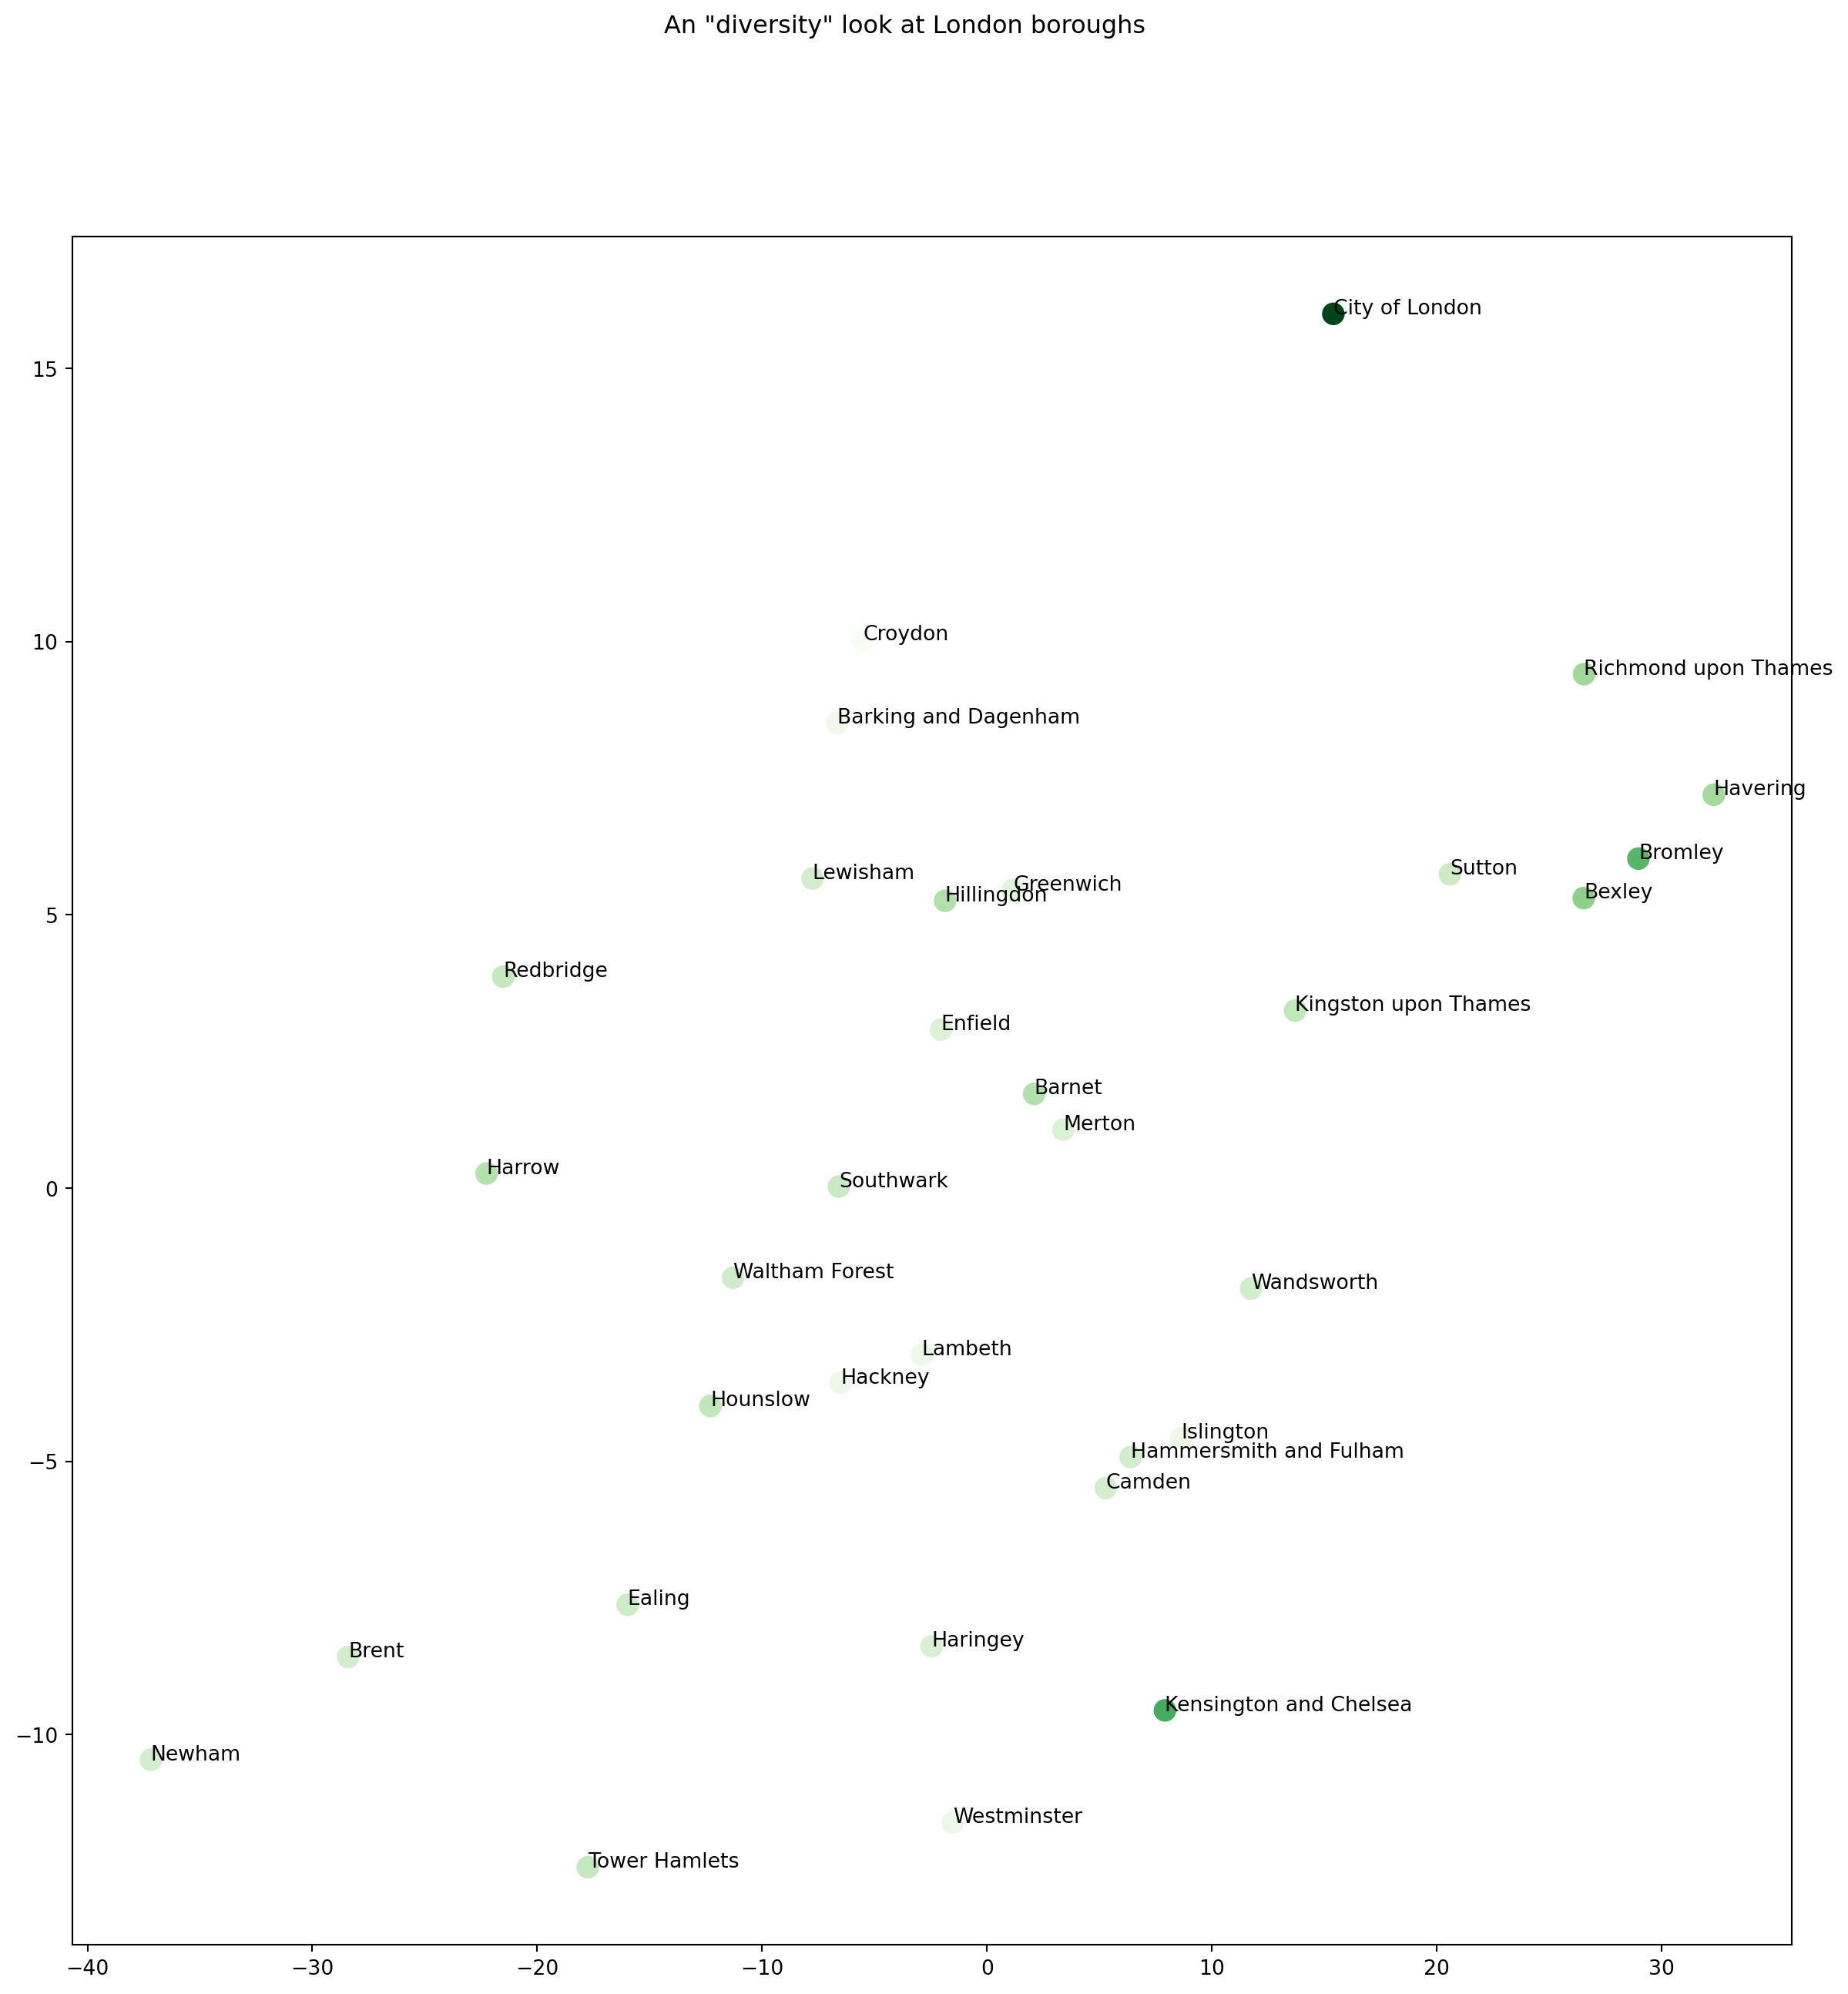

In [14]:
#| column: page

# get the data columns relating to emotions and feelings
dataOnDiversity = numericColumns[["Proportion of population aged 0-15, 2013", "Proportion of population of working-age, 2013", "Proportion of population aged 65 and over, 2013", "% of population from BAME groups (2013)", "% people aged 3+ whose main language is not English (2011 census)"]]

# a new distance matrix to represent "emotional distance"s
distMatrix3 = euclidean_distances(dataOnDiversity, dataOnDiversity)

mds = manifold.MDS(n_components = 2, max_iter=3000, n_init=1, dissimilarity="precomputed", normalized_stress = False)
Y = mds.fit_transform(distMatrix3)

# Visualising the data.
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
plt.suptitle('An \"diversity\" look at London boroughs')
ax.scatter(Y[:, 0], Y[:, 1], s = 100, c = colorMappingValuesHappiness, cmap=plt.cm.Greens)

for i, txt in enumerate(placeNames):
    ax.annotate(txt, (Y[:, 0][i],Y[:, 1][i]))

::: callout-caution

## It is now your turn!

### First task: 

This looks very different to the one above on "emotion" related variables. Our job now is to relate these two projections to one another. Do you see similarities? Do you see clusters of boroughs? Can you reflect on how you can relate and combine these two maps conceptually?

### Second task:
Can you think of and then generate other maps that you can produce with this data? Have a look at the variables once again and try to produce new "perspectives" to the data and see what they have to say. 

Also think of visualisations to help you here, can you colour them with a different variable? What would that change?

:::
